# SYDE 556/750 --- Assignment 3
**Student ID: 20854840**

*Note:* Please include your numerical student ID only, do *not* include your name.

*Note:* Refer to the [PDF](https://github.com/celiasmith/syde556-f22/raw/master/assignments/assignment_03/syde556_assignment_03.pdf) for the full instructions (including some hints), this notebook contains abbreviated instructions only. Cells you need to fill out are marked with a "writing hand" symbol. Of course, you can add new cells in between the instructions, but please leave the instructions intact to facilitate marking.

In [1]:
# Import numpy and matplotlib -- you shouldn't need any other libraries
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy
from scipy.integrate import quad

# Change Seed whenever needed to get reproducible results
seed  = 2085484018

# Fix the numpy random seed for reproducible results
np.random.seed(seed)

# Some formating options
%config InlineBackend.figure_formats = ['svg']

# 1. Decoding from a population

**a) Tuning curves.** Plot the tuning curves (firing rate of each neuron for different $x$ values between $-2$ and $2$).

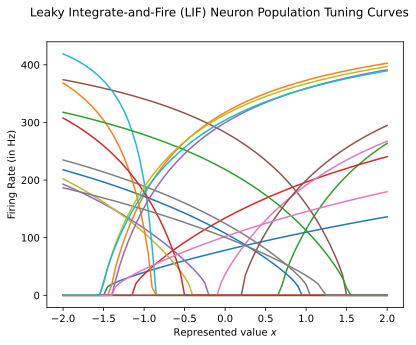

In [2]:
# Establish number of neurons

numNeurons = 20

tauRef = 0.002
tauRC = 0.020

# Generate max firing rate that is uniformly distributed with given freqs

lowFreq = 100
highFreq = 200
numSamplesaMax = numNeurons # Getting the number of neurons as samples
setaMax= np.random.uniform(lowFreq, highFreq, numSamplesaMax)


# print(setaMax) --> ignore this is me testing some kernels stuff


# generate random intercepts (x intercepts b/w given limits)

minIntercept = -2
maxIntercept = 2
numSamplesintercepts = numNeurons
setIntercept = np.random.uniform(minIntercept, maxIntercept, numSamplesintercepts)

# print(setIntercept) --> ignore this is me testing some kernels stuff


def calculateGain(aMax, xIntercept, e, neuronType):
    if neuronType == "lif" or neuronType == "lif-2d":
        expTerm = np.exp((tauRef - (1 / aMax)) / (tauRC))
        return (-expTerm)/((1-expTerm)*(1-xIntercept))
    return 0

def calculateBias(xIntercept, e, gain, neuronType, aMax):
    if neuronType == "lif":
        expTerm = np.exp((tauRef - (1 / aMax)) / (tauRC))
        return (1-expTerm-xIntercept)/((1-expTerm)*(1-xIntercept))
    if neuronType == "lif-2d":
        return -(gain) * np.vdot(e, xIntercept)
    return 0

def lifEncode(neuron, x):
    J = neuron.a * x * neuron.encoderSign + neuron.jBias
    if J > 1:
        return 1 / (tauRef - tauRC * np.log(1 - (1 / J)))
    return 0

def calculateRMSE(x1, x2):
    return np.sqrt(np.mean((x1 - x2) ** 2))

class Neuron:
    def __init__(self, aMax, xIntercept, id, neuronType):
        self.id = id
        self.aMax = aMax
        self.encoderSign = np.random.choice([-1, 1])
        a = calculateGain(aMax, xIntercept, self.encoderSign, neuronType)
        jBias = calculateBias(xIntercept, self.encoderSign, a, neuronType, aMax)
        self.a = a
        self.jBias = jBias
        self.rate = []

    def rateAtPoint(self, x, neuronType):
        if neuronType == "lif":
            return lifEncode(self, x)

    def findRate(self, space, neuronType):
        for element in space:
            self.rate.append(self.rateAtPoint(element, neuronType))

# Create neurons
# Define the number of neurons and other parameters

setaMax = np.random.uniform(lowFreq, highFreq, numNeurons)
setIntecept = np.random.uniform(minIntercept, maxIntercept, numNeurons)

lifNeurons = [Neuron(setaMax[i], setIntercept[i], i, "lif") for i in range(numNeurons)]

# Create a linspace for plotting
xAxis = np.linspace(-2, 2, 81)

# Calculate rates for each LIF neuron
for neuron in lifNeurons:
    neuron.findRate(xAxis, "lif")

plt.suptitle("Leaky Integrate-and-Fire (LIF) Neuron Population Tuning Curves")
for neuron in lifNeurons:
    plt.plot(xAxis, neuron.rate)
plt.xlabel("Represented value $x$")
plt.ylabel("Firing Rate (in Hz)")
plt.show()


**b) Decoder and error computation.** Compute the decoders and plot $(x-\hat{x})$. When computing decoders, take into account noise ($\sigma=0.1 \cdot 200\,\mathrm{Hz}$). When computing $\hat{x}$, add random Gaussian noise with $\sigma=0.1 \cdot 200\,\mathrm{Hz}$ to the activity. Report the Root Mean-Squared Error (RMSE).

In [3]:
# Initialize lists for LIF activities and inputs
lifActivities = []
lifInputs = []

# Populate LIF activities and inputs lists
for neuron in lifNeurons:
    lifActivities.append(neuron.rate)
    lifInputs.append(xAxis)

# Create A matrix and matrix of activities
ALIF = np.array(lifActivities)
XLIF = np.array(lifInputs)

# Calculate LIF noise standard deviation
stdDevLIF = 0.1*200

# Generate noise matrix WNoiseLIF
WNoiseLIF = np.random.normal(scale=stdDevLIF, size=ALIF.shape)

# Add noise to A to create ANoiseLIF
ANoiseLIF = ALIF + WNoiseLIF

nLIF = numNeurons
NLIF = len(xAxis)
# Decoder with noise
dNoiseLIF = np.linalg.lstsq(ALIF @ ALIF.T + NLIF * np.square(stdDevLIF) * np.eye(nLIF), ALIF @ XLIF.T,rcond=None)[0].T[0]

# Compute xHat wit noisy acitivities
xHat = np.matmul(dNoiseLIF, ANoiseLIF)

print("---------------------------------------------------------------------------------------------------------")
print("Decoders for Noisy LIF =")
print(dNoiseLIF)
print("---------------------------------------------------------------------------------------------------------")

error = xAxis-xHat

xRMSE = calculateRMSE(xAxis, xHat)
xRMSE_rounded = np.round(xRMSE, 5)
print("---------------------------------------------")
print("Root Mean Squared Error =", xRMSE_rounded)
print("---------------------------------------------")


---------------------------------------------------------------------------------------------------------
Decoders for Noisy LIF =
[ 0.00045295  0.00028417  0.00057469  0.00058342 -0.00102091 -0.00139284
  0.00126759 -0.00055329 -0.00071039  0.00021446 -0.00058433 -0.00023654
 -0.00128512 -0.0006425   0.0002736   0.00071445  0.00045703 -0.00050991
  0.00072582  0.0007579 ]
---------------------------------------------------------------------------------------------------------
---------------------------------------------
Root Mean Squared Error = 0.10635
---------------------------------------------


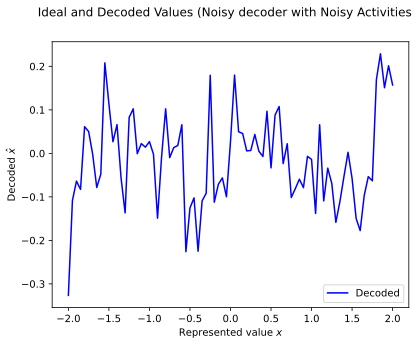

In [4]:
plt.suptitle("Ideal and Decoded Values (Noisy decoder with Noisy Activities")
# plt.plot(xAxis,xAxis,"r", linestyle="dashed", label="Ideal")
plt.plot(xAxis,error, "b", label="Decoded")
plt.xlabel("Represented value $x$")
plt.ylabel("Decoded $\hat x$")
plt.legend()

# 2. Decoding from two spiking neurons

**a) Synaptic filter.** Plot the post-synaptic current
		$$
			h(t)= \begin{cases}
				0 & \text{if } t < 0 \,, \\
				\frac{e^{-t/\tau}}{\int_0^\infty e^{-t'/\tau} \mathrm{d}t'} & \text{otherwise} \,.
			\end{cases}
		$$

/var/folders/vx/4n9y5hq95dj5b30w8b75ms1h0000gn/T/ipykernel_41702/1231264916.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(index[0])


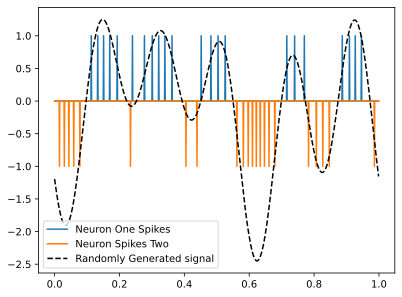

In [18]:
minRate = 20
maxRate = 50

T, dt, rms, limit = 1, 0.001, 1, 5

def randComplex():
    return np.random.normal() + np.random.normal() * 1j

#If symmetry exists, it returns a boolean indicating its existence and the index where the symmetric element is located.
def symmetryExists(f, F):
    neg = -f
    return neg in F and f != 0, np.where(F == neg)

# Calculate signal RMS
def signalRMS(signal):
    return np.sqrt(np.mean(np.power(signal, 2)))

# Calculates the current RMS of the signal and then scales all elements to achieve the desired RMS.
def rescaleSignal(signal, idealRMS):
    currentRMS = signalRMS(signal)
    rescaledSignal = [p * idealRMS / currentRMS for p in signal]
    return rescaledSignal

def locations(index):
    return int(index[0])


# It's a way to ensure that the frequency domain and signal values remain aligned.
def tuplify(F, Z):
    return (list(tt) for tt in zip(*sorted(zip(F, Z))))

def calcRmse(x1, x2):
    return np.sqrt(np.mean(np.power(x1 - x2, 2)))

def generate_signal(T, dt, rms, limit, seed):

    if seed != 0:
        np.random.seed(int(seed))
    # generate a times scale
    timescale = np.arange(0, T, dt)
    # get the number of points so that we can create a signal in the frequency domain
    num_pts = len(timescale)
    # convert to frequency domain
    F = fft.fftfreq(num_pts, dt)
    # create a frequenct signal of zeros
    length_F = len(F)
    # create zeros for the frequency domain
    zeros = np.zeros(length_F)
    Z = zeros.tolist()

    for idx, f in enumerate(F):
        if Z[idx] == 0:
            magnitude_f = abs(f)
            if magnitude_f <= limit:
                im = randComplex()
                Z[idx] = im
                # ensure that we account for the negative symmetric value
                exists, index = symmetryExists(f, F)
                if exists:
                    location = locations(index)
                    # assig it to the complex conjugate
                    Z[location] = np.conj(im)
        else:
            continue
    # perform inverse fft
    z = fft.ifft(Z)
    # select the real components
    z = z.real
    # rescale based on the current and ideal rmse
    z = rescaleSignal(z, rms)

    # convert back to frequency domain
    Z = fft.fft(z)
    # touple Z so that it aligns with our intial number of samples
    F, Z = tuplify(F, Z)
    return z, Z


class spiking_neuron:
    # Initialize values needed for the spikes
    def __init__(self, e=1, tauRef=0.002, tauRC=0.02):

        self.minRate = minRate
        self.maxRate = maxRate
        self.e = e
        self.tauRef = tauRef
        self.tauRC = tauRC

        
        # calculate gain and bias for the spiking neuron
        self.jBias = 1/(1-np.exp((self.tauRef-(1/self.minRate))/self.tauRC))
        self.alpha = 1/(1-np.exp((self.tauRef-(1/self.maxRate))/self.tauRC))-self.jBias

    
    def spikey(self, x, dt):

        num_refSteps = np.floor(self.tauRef/dt)
        spikeCount = 0
        voltages=[]
        refCount = 0
        V = 0
        vNext = 0
        self.spikes=[]
        
        for stimuli in x:
            J = self.alpha*stimuli*self.e+self.jBias
            if refCount > 0:
                V = 0
                refCount -= 1
                self.spikes.append(0)
            else:
                if V >= 1: # Spike everytime the voltage surpases 1
                    V = 1 # Constant spike voltage for the neuron, picked Vth as designer
                    refCount = num_refSteps #+ 1
                    spikeCount +=1
                    self.spikes.append(self.e)
                    V=0
                elif V < 0: # Make sure the voltage is positive, else reset to 0
                    self.spikes.append(0)
                    V = 0
                else: self.spikes.append(0)
            vNext = V + dt*(1/self.tauRC)*(J-V) # Next voltage for spike, derived from core diff equation of LIF
            voltages.append(V)
            V = vNext
            spiked = self.spikes


        return voltages, spikeCount, spiked

# Construct neuron with specific rates and encoders  
xRandom, _ = generate_signal(T, dt, rms, limit, seed)  
neuronOne = spiking_neuron(e=1)
neuronTwo = spiking_neuron(e=-1)

t = np.arange(0,T,dt)
x_zero = [0 for time in t]

voltage_neuronOne, numSpikes_neuronOne, spikes_neuronOne = neuronOne.spikey(xRandom, dt)
voltage_neuronTwo, numSpikes_neuronTwo, spikes_neuronTwo = neuronTwo.spikey(xRandom, dt)




plt.plot(t, spikes_neuronOne, label="Neuron One Spikes")
plt.plot(t, spikes_neuronTwo, label= "Neuron Spikes Two")
plt.plot(t, xRandom, label="Randomly Generated signal", linestyle="dashed", color = "black")
plt.legend()






**b) Decoding using a synaptic filter.** Plot the original signal $x(t)$, the spikes, and the decoded $\hat{x}(t)$ all on the same graph.

In [6]:
# ✍ <YOUR SOLUTION HERE>

**c) Error analysis.** Compute the RMSE of the decoding.

In [7]:
# ✍ <YOUR SOLUTION HERE>

# 3. Decoding from many neurons

**a) Exploring the error for an increasing neuron count.** Plot the Root Mean-Squared Error as the number of neurons increases, on a log-log plot. Try $8$ neurons, $16$ neurons, $32$, $64$, $128$, up to $256$. For the RMSE for a particular number of neurons, average over at least $5$ randomly generated groups of neurons. For each group of neurons, randomly generate the signal $x(t)$. Use the same parameters as in question 2.

In [8]:
# ✍ <YOUR SOLUTION HERE>

**b) Discussion.** Discuss your results. What is the systematic relationship between the neuron count and the error?

✍ \<YOUR SOLUTION HERE\>

# 4. Connecting two groups of neurons

**a) Computing a function.** Show the behaviour of the system with an input of $x(t)=t-1$ for $1\,\mathrm{s}$ (a linear ramp from $-1$ to $0$). Plot the ideal $x(t)$ and $y(t)$ values, along with $\hat{y}(t)$.

In [9]:
# ✍ <YOUR SOLUTION HERE>

**b) Step input.** Repeat part (a) with an input that is ten randomly chosen values between -1 and 0, each one held for 0.1 seconds (a randomly varying step input)

In [10]:
# ✍ <YOUR SOLUTION HERE>

**c) Sinusoidal input.** Repeat part (a) with an input that is $x(t)=0.2\sin(6\pi t)$.

In [11]:
# ✍ <YOUR SOLUTION HERE>

**d) Discussion.** Briefly discuss the results for this question. Does the output match the ideal output? What kind of deviations do you see and why do those exist?

✍ \<YOUR SOLUTION HERE\>

# 5. Connecting three groups of neurons

**a) Sinusoidal input.** Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for an input of $x(t)=\cos(3\pi t)$ and $y(t)=0.5 \sin (2 \pi t)$ (over $1\,\mathrm{s}$).

In [12]:
# ✍ <YOUR SOLUTION HERE>

**b) Random input.** Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for a random input over $1\,\mathrm{s}$. For $x(t)$ use a random signal with a limit of $8\,\mathrm{Hz}$ and $\mathtt{rms}=1$. For $y(t)$ use a random signal with a limit of $5\,\mathrm{Hz}$ and $\mathtt{rms}=0.5$.

In [13]:
# ✍ <YOUR SOLUTION HERE>

# 6. Computing with vectors

**a) Constant inputs.** Plot the decoded output $\hat{w}(t)$ and the ideal $w$ for
		$$x =(0.5,1), \quad y = (0.1,0.3), \quad z =(0.2,0.1), \quad q = (0.4,-0.2) \,.$$

In [14]:
# ✍ <YOUR SOLUTION HERE>

**b) Sinusoidal input.** Produce the same plot for
$$x =(0.5,1), \quad y = (\sin(4\pi t),0.3), \quad z =(0.2,0.1), \quad q = (\sin(4\pi t),-0.2) \,.$$

In [15]:
# ✍ <YOUR SOLUTION HERE>

**c) Discussion.** Describe your results and discuss why and how they stray from the expected answer.

✍ \<YOUR SOLUTION HERE\>